# Figure X. Trajectory table

Imports.

In [1]:
%load_ext autoreload
%autoreload 2
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

measure = 'sigma'
trial_indices = defaultdict(int)
records = []
path = '../../dgym-data/analysis/noise/selection_noise_2024-05-10_23-36-56_continued.zip'
with zipfile.ZipFile(path, 'r') as z:
    for filename in tqdm(z.namelist()):
        with z.open(filename) as file:
            with TextIOWrapper(file, encoding='utf-8') as text_file:
                result = json.load(text_file)
                
                # Get annotations
                record = pd.DataFrame(result['annotations']).reindex(
                    columns=[
                        'SMILES',
                        'Inspiration',
                        'Current Status',
                        'ABL1 pIC50',
                        'Log P',
                        'Log S',
                        'Noisy ABL1 pIC50',
                        'Noisy Log P',
                        'Noisy Log S',
                        'Step Tested',
                        'Step Scored',
                        'Synthetic Route',
                    ]
                )
                
                # Get trial number
                value = result[measure]
                trial_indices[value] += 1
                record[measure] = value
                record['trial'] = trial_indices[value]

                # Append
                records.append(record)
df = pd.concat(records)
records = None

  0%|          | 0/500 [00:00<?, ?it/s]

Score utility.

In [3]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction(
    utility_functions = [docking_utility_function, log_P_utility_function, log_S_utility_function],
    weights = [0.8, 0.1, 0.1]
)

df['utility'] = composite_utility_function(
    df[['ABL1 pIC50', 'Log P', 'Log S']].values,
    precompute=True,
    method='average'
)

### Parse molecules

In [425]:
import ast
import dgym as dg
import numpy as np

subset = df.query('sigma == 1.0').query('trial == 47') # .query('sigma == 2.0').query('trial == 2')
current_row = subset.query('utility == 1.0').iloc[0]
lineage = []
while True:
    # Parse Molecule
    best = dict(current_row)
    route = best.pop('Synthetic Route')
    
    # Normalize inputs
    if isinstance(route, str):
        route = ast.literal_eval(route)
    if isinstance(best['Inspiration'], float):
        del best['Inspiration']
    route['annotations'] = best

    # Create Molecule
    mol = dg.molecule.Molecule.load(route)
    
    # Append Molecule
    lineage.append(mol)
    
    # Iterate to ancestor
    if not mol.inspiration:
        break

    inspiration_smiles = mol.inspiration.smiles
    current_row = subset.query(
        f'SMILES == "{inspiration_smiles}"').iloc[0]
    
lineage = dg.collection.MoleculeCollection(lineage)

### Fill out missing annotations

Load Oracles.

In [426]:
import os

def get_tcp_objectives():

    dockstring_dir = f'../../dgym-data/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'../../dgym-data//dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle

In [427]:
import dgym as dg
import io
from contextlib import redirect_stdout
f = io.StringIO()

with redirect_stdout(f):
    untested = lineage[lineage.annotations.isna().any(axis=1)]
    pIC50_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()
    for idx, result in enumerate(pIC50_oracle(untested, batch_size=40)):
        untested[idx]['ABL1 pIC50'] = result
    for idx, result in enumerate(log_P_oracle(untested, batch_size=40)):
        untested[idx]['Log P'] = result
    for idx, result in enumerate(log_S_oracle(untested, batch_size=40)):
        untested[idx]['Log S'] = result

In [428]:
from rdkit.Chem import Draw

def plot_aligned_molecules(
    molecules,
    mols_per_row=3,
    use_svg=True
):
    """
    Plots a list of RDKit molecules.

    Parameters
    ----------
    molecules : list
        A list of RDKit molecule objects.
    """
    mols = [m.mol for m in molecules]
    img = Draw.MolsToGridImage(
        mols,
        subImgSize=(250, 250),
        molsPerRow=mols_per_row,
        useSVG=use_svg,
    )
    return img

In [429]:
for idx, _ in enumerate(lineage):
    if idx < len(lineage) - 1:
        lineage[idx].inspiration = lineage[idx+1]

aligned_molecules = dg.utils.align_lineage(lineage[0])

In [ ]:
lineage.annotations

,SMILES,Inspiration,Current Status,ABL1 pIC50,Log P,Log S,Noisy ABL1 pIC50,Noisy Log P,Noisy Log S,Step Tested,Step Scored,sigma,trial,utility,Progress,Design Cycle,Reactants,Synthetic Route
0,CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(=O)N(C(=O)C3(...,CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(=O)N(C(=O)C3(...,Tested,9.603198,1.0329,-3.454926,9.726433,1.845816,-3.269023,16.0,15.0,1.0,47,1.000000,100.000000,1,[CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(=O)N(C(=O)C3...,{'product': 'CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(...
1,CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(=O)N(C(=O)C3(...,CC1(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O)C5(C)CCN5)C(...,Tested,8.541703,1.0883,-3.698948,9.584276,1.952627,-3.847745,14.0,13.0,1.0,47,0.633363,86.666667,1,[CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(=O)NC4)C(=O)...,{'product': 'CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(...
2,CC1(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O)C5(C)CCN5)C(...,CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)CN(C(=O)C3(C)CC...,Tested,8.993338,1.0883,-3.706202,9.311323,0.956327,-3.553607,9.0,8.0,1.0,47,0.994670,53.333333,1,[CC1(C(=O)N2Cc3ccc(C(=O)N4CCNC(=O)C4)cc3C2=O)C...,{'product': 'CC1(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O...
3,CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)CN(C(=O)C3(C)CC...,CC1(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O)c5coc(Br)c5)...,Tested,8.966728,1.4481,-4.212364,10.215034,1.834589,-2.927335,7.0,6.0,1.0,47,0.826400,40.000000,1,[CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)CNC4)C(=O)C2)C...,{'product': 'CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)CN...
4,CC1(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O)c5coc(Br)c5)...,CC1(C(=O)N2Cc3ccc(C(=O)N4CCNCC4=O)cc3C2)CC=CC1,Tested,9.013923,3.3654,-4.129665,10.252977,4.144418,-4.001264,5.0,4.0,1.0,47,0.872386,26.666667,1,[CC1(C(=O)N2Cc3ccc(C(=O)N4CCNCC4=O)cc3C2)CC=CC...,{'product': 'CC1(C(=O)N2Cc3ccc(C(=O)N4CCN(C(=O...
5,CC1(C(=O)N2Cc3ccc(C(=O)N4CCNCC4=O)cc3C2)CC=CC1,CSSC(C)(C)C(=O)N1CCN(C(=O)c2ccc3c(c2)CNC3)CC1=O,Tested,8.572962,1.4571,-3.656068,9.111222,1.125159,-4.089883,2.0,1.0,1.0,47,0.658370,6.666667,1,"[O=C1CNCCN1C(=O)c1ccc2c(c1)CNC2, CC1(C(=O)O)CC...",{'product': 'CC1(C(=O)N2Cc3ccc(C(=O)N4CCNCC4=O...
6,CSSC(C)(C)C(=O)N1CCN(C(=O)c2ccc3c(c2)CNC3)CC1=O,O=C1CN(C(=O)c2ccc3c(c2)CNC3)CCN1,Tested,7.337919,1.8906,-3.498826,7.418143,1.084305,-4.742820,1.0,0.0,1.0,47,-1.210011,0.000000,1,"[O=C1CN(C(=O)c2ccc3c(c2)CNC3)CCN1, CSSC(C)(C)C...",{'product': 'CSSC(C)(C)C(=O)N1CCN(C(=O)c2ccc3c...
7,O=C1CN(C(=O)c2ccc3c(c2)CNC3)CCN1,O=C1CN(C(=O)c2ccccc2C(F)(F)F)CCN1,Tested,7.451133,-0.1382,-2.100419,9.321053,-1.107565,0.095729,1.0,0.0,1.0,47,-0.919190,0.000000,1,"[O=C1CNCCN1, Cl.O=C(O)c1ccc2c(c1)CNC2]",{'product': 'O=C1CN(C(=O)c2ccc3c(c2)CNC3)CCN1'...
8,O=C1CN(C(=O)c2ccccc2C(F)(F)F)CCN1,NaN,None,6.878363,1.2774,-2.279370,NaN,NaN,NaN,NaN,NaN,1.0,47,-1000.000000,NaN,0,"[O=C1CNCCN1, O=C(O)c1ccccc1C(F)(F)F]",{'product': 'O=C1CN(C(=O)c2ccccc2C(F)(F)F)CCN1...


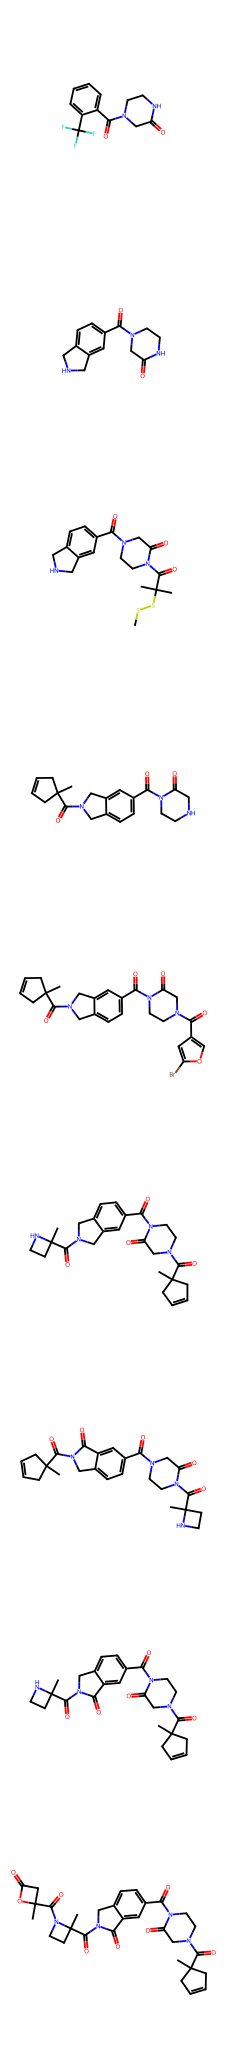

In [433]:
plot_aligned_molecules(aligned_molecules, mols_per_row=1, use_svg=True)

## Representative early-optimization molecules

In [242]:
# Convert step made to Progress of Series as in Novartis paper.
df['Progress'] = (
    df
    .groupby(['sigma', 'trial'])['Step Scored']
    .transform(lambda x: x / x.max() * 100)
)

In [293]:
progresses = [0, 1, 2, 5, 10, 20, 40, 80, 99]
mol_progress = []
for progress in progresses:
    if progress == 0:
        subset = df[df['Inspiration'].isna()]
    else:
        subset = (
            df
            .query(f'Progress > {progress}')
            .query(f'Progress < {progress} + 1')
        )
    representative_molecules = [dg.molecule.Molecule(
        subset
        .sample()['SMILES']
        .item()
    ) for _ in range(4)]
    mol_progress.append(representative_molecules)
mols = np.array(mol_progress).T.ravel()

In [290]:
from rdkit.Chem import AllChem
import rdkit.Chem.Draw
from rdkit.Chem.Draw import rdMolDraw2D
try:
    import Image
except ImportError:
    from PIL import Image
from io import BytesIO

def DrawMolsZoomed(mols, molsPerRow=3, subImgSize=(500, 500)):
    """
    From https://sourceforge.net/p/rdkit/mailman/message/36477772/
    """
    nRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow: nRows += 1
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
    full_image = Image.new('RGBA', fullSize )
    for ii, mol in enumerate(mols):
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
        column = ii % molsPerRow
        row = ii // molsPerRow
        offset = ( column * subImgSize[0], row * subImgSize[1] )
        d2d = rdMolDraw2D.MolDraw2DCairo(int(subImgSize[0] * 0.75), subImgSize[1])
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()
        sub = Image.open(BytesIO(d2d.GetDrawingText()))
        full_image.paste(sub,box=offset)
    return full_image

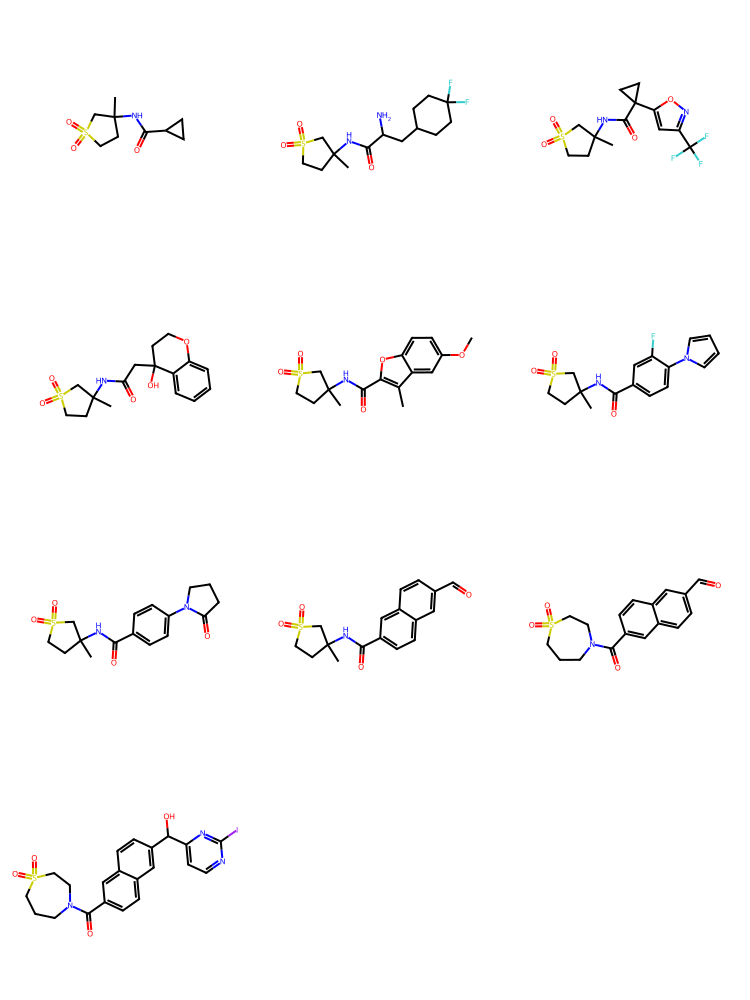

In [312]:
plot_aligned_molecules(aligned_molecules, mols_per_row=3)

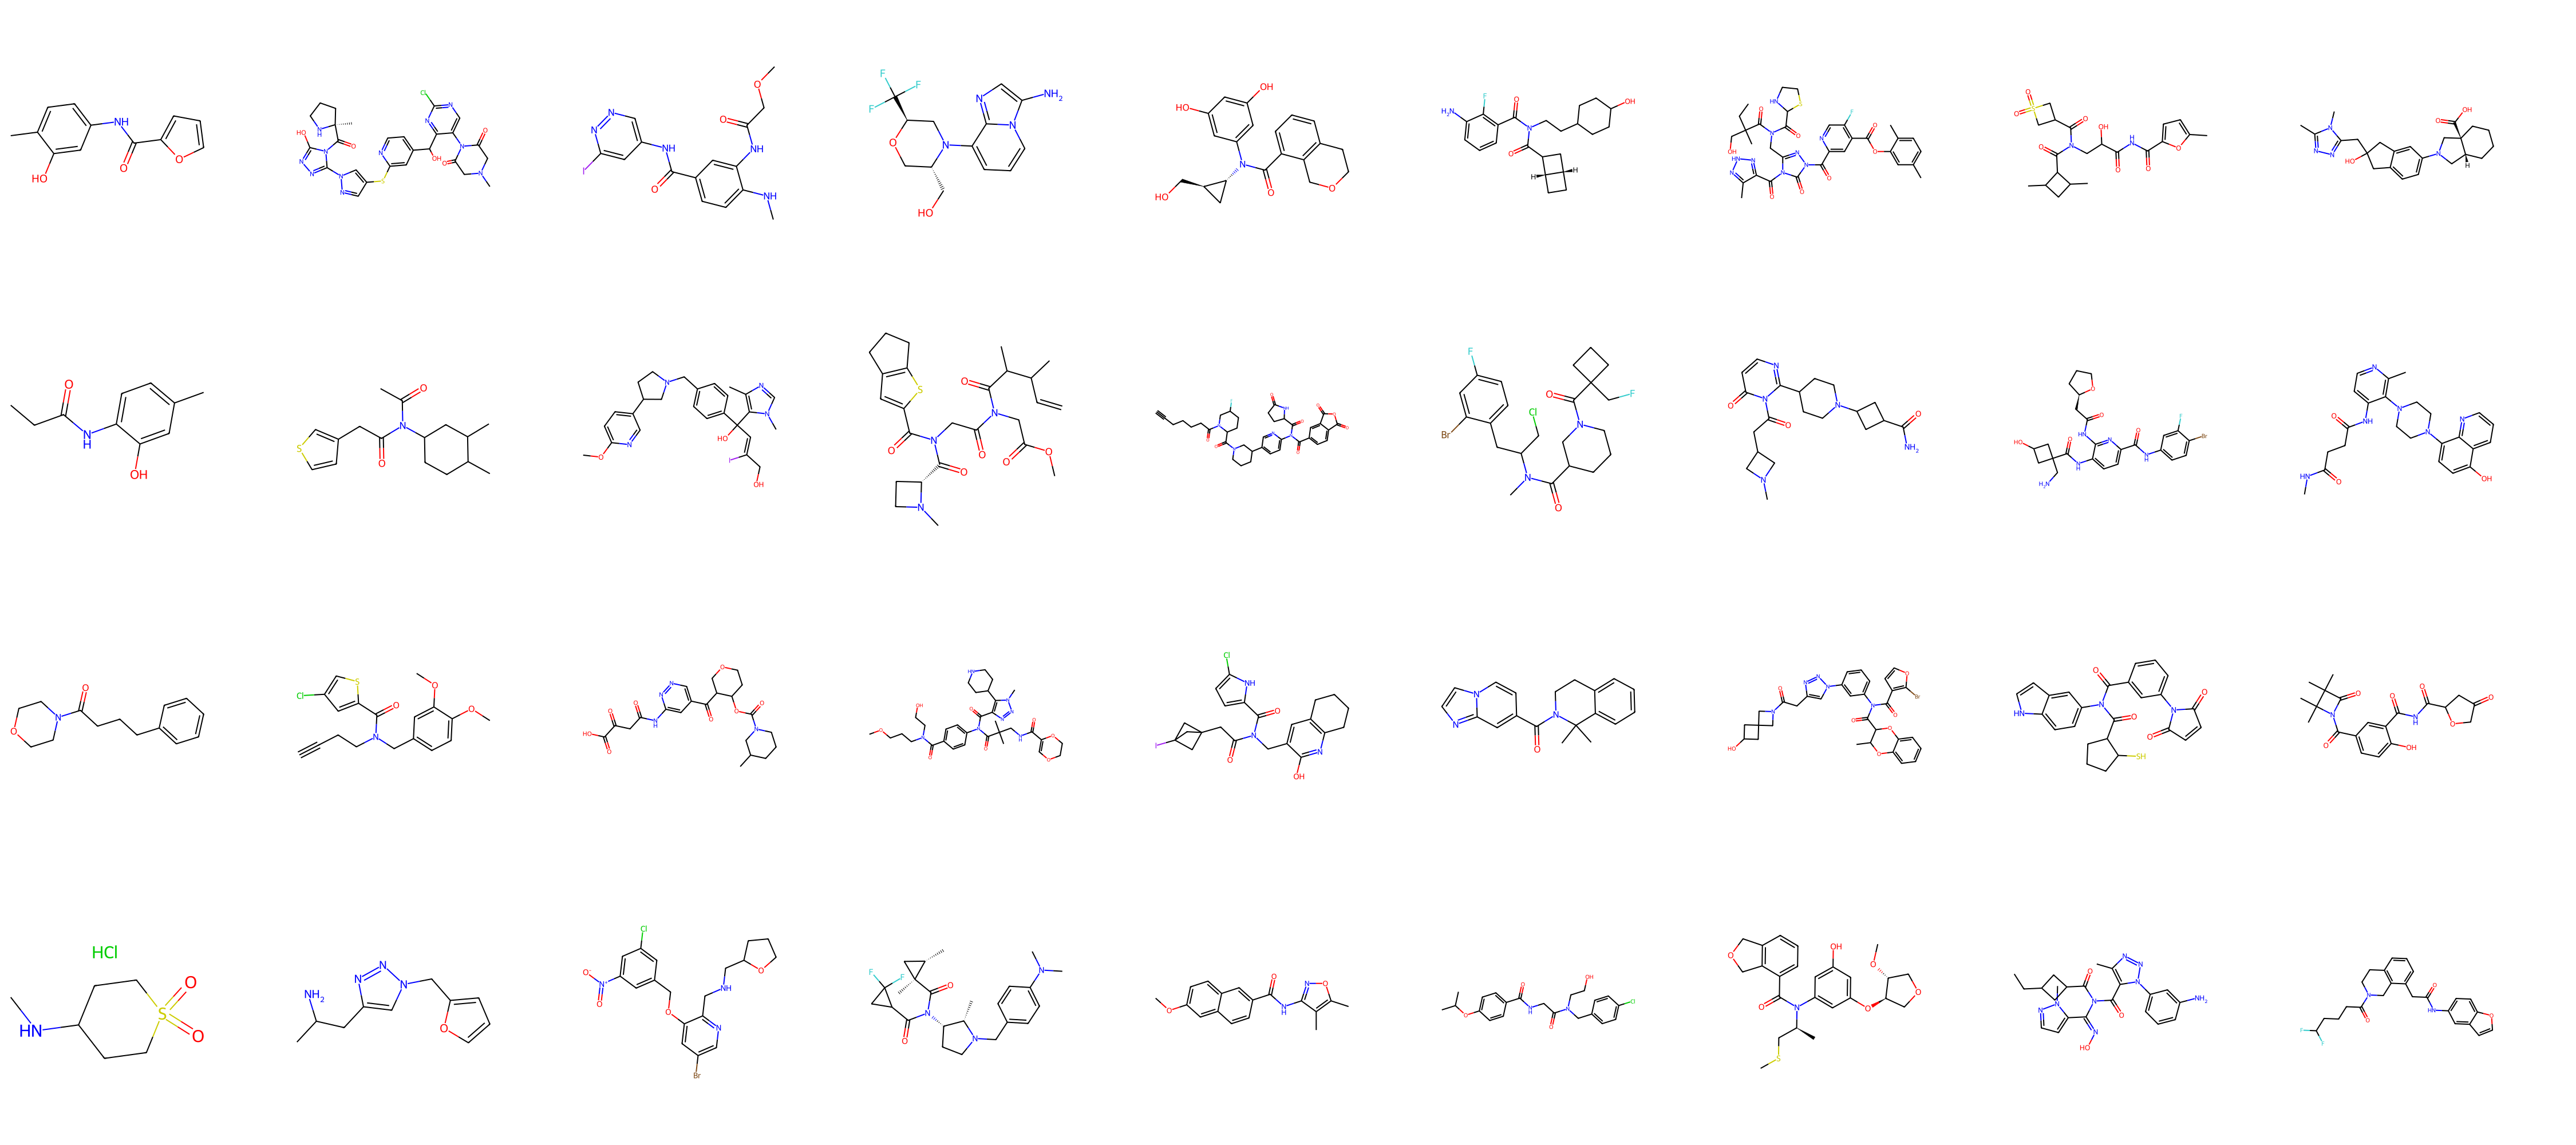

In [310]:
DrawMolsZoomed([m.mol for m in mols], molsPerRow=9)

## Representative reaction

In [422]:
great_example = (
    df
    .query('sigma == 1.0')
    .query('Progress == 100')
    .sort_values('ABL1 pIC50', na_position='last', ascending=False)
    .iloc[1]
)

In [423]:
great_example

SMILES              CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(=O)N(C(=O)C3(...
Inspiration         CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(=O)N(C(=O)C3(...
Current Status                                                 Tested
ABL1 pIC50                                                   9.603198
Log P                                                          1.0329
Log S                                                       -3.454926
Noisy ABL1 pIC50                                             9.726433
Noisy Log P                                                  1.845816
Noisy Log S                                                 -3.269023
Step Tested                                                      16.0
Step Scored                                                      15.0
Synthetic Route     {'product': 'CC1(C(=O)N2CCN(C(=O)c3ccc4c(c3)C(...
sigma                                                             1.0
trial                                                              47
utility             

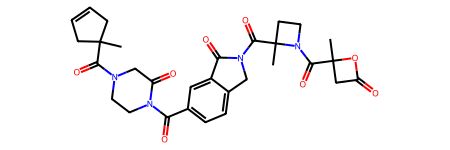

In [424]:
dg.molecule.Molecule(great_example['SMILES'])